In [1]:
# 以沪深300数据集为例，构建特征和目标值，使用线性回归模型(OLS方法)拟合特征与目标值，并评估模型
import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df = pd.read_csv('D:/Desktop/csi300.csv')
df.set_index(['datetime', 'instrument'], inplace=True)
df

open      close       high        low  \
datetime   instrument                                               
2014-01-02 SH600000     6.346357   6.346357   6.427982   6.319149   
           SH600008     2.669297   2.669297   2.693094   2.649466   
           SH600009     2.104700   2.104700   2.110510   2.077102   
           SH600010     3.032141   3.032141   3.032141   3.032141   
           SH600011     1.249862   1.249862   1.262237   1.239962   
...                          ...        ...        ...        ...   
2021-06-11 SZ300595    35.558136  35.558136  35.910620  34.085000   
           SZ300601    48.747370  48.747370  49.121680  46.739445   
           SZ300628     0.660397   0.660397   0.672620   0.649076   
           SZ300676     6.135177   6.135177   6.274753   6.079757   
           SZ300677     9.695190   9.695190   9.862881   9.542920   

                            volume  vwap  
datetime   instrument                     
2014-01-02 SH600000    102646320.0   NaN  
           SH600008     17887876.0   NaN  
           SH600009     40825604.0   NaN  
           SH600010     38820620.0   NaN  
           SH600011     46853836.0   NaN  
...                            ...   ...  
2021-06-11 SZ300595     32497936.0   NaN  
           SZ300601     24171926.0   NaN  
           SZ300628    265433060.0   NaN  
           SZ300676    106571120.0   NaN  
           SZ300677    157382940.0   NaN  

[541712 rows x 6 columns]

In [3]:
# 清洗数据
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 541712 entries, ('2014-01-02', 'SH600000') to ('2021-06-11', 'SZ300677')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    523789 non-null  float64
 1   close   523789 non-null  float64
 2   high    523789 non-null  float64
 3   low     523789 non-null  float64
 4   volume  523789 non-null  float64
 5   vwap    0 non-null       float64
dtypes: float64(6)
memory usage: 27.0+ MB


In [4]:
df = df.drop(['vwap'], axis=1)
df = df.groupby(['instrument']).fillna(method='ffill').dropna()
df.describe()

,open,close,high,low,volume
count,541431.000000,541431.000000,541431.000000,541431.000000,5.414310e+05
mean,9.272320,9.272320,9.441487,9.099892,2.328401e+08
std,17.509698,17.509698,17.838700,17.162977,5.951320e+08
min,0.123253,0.123253,0.123862,0.122949,6.030582e+04
25%,1.628318,1.628318,1.657480,1.602987,2.752348e+07
50%,4.284040,4.284040,4.360400,4.202066,7.235930e+07
75%,10.514965,10.514965,10.700786,10.323152,2.021913e+08
max,295.249540,295.249540,296.952900,288.305480,3.626895e+10


In [5]:
# 下面开始构造目标值和特征
df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

df['lastclose'] = df['close'].groupby(['instrument']).shift(1)
feature_kwargs = {
    'data': df,
    'price': 'close',
    'label': 'label',
    'last_close': 'lastclose',
    'volume': 'volume',
    'amount': None,
    'high': 'high',
    'low': 'low',
    'shift': 2,
    'groupby': 'instrument'
}
features = alpha.make_factors(feature_kwargs, windows=[5, 10, 20, 60])
X = pd.concat([features, df['label']], axis=1)

X.describe()

,ma5,std5,max5,min5,beta5,roc5,ma10,std10,max10,min10,...,risk60,hml5,hml10,hml20,hml60,rsv5,rsv10,rsv20,rsv60,label
count,538030.000000,538030.000000,538030.000000,538030.000000,5.402860e+05,5.402860e+05,535210.000000,535210.000000,535210.000000,535210.000000,...,507574.000000,5.391580e+05,5.363380e+05,5.306980e+05,5.081380e+05,539158.000000,536338.000000,530698.000000,508138.000000,540286.000000
mean,0.000665,0.000665,0.027617,-0.025110,1.262629e-06,-2.853643e+05,0.000679,0.000679,0.038281,-0.034301,...,0.000313,3.415936e-01,3.416430e-01,3.417483e-01,3.421086e-01,3.548728,3.534811,3.503490,3.380081,0.000642
std,0.014271,0.014271,0.045383,0.023098,8.882884e-03,7.042447e+07,0.010073,0.010073,0.060224,0.025535,...,0.003556,7.576333e-01,7.460013e-01,7.347846e-01,7.087809e-01,14.267055,14.227233,14.117650,13.721310,0.031288
min,-0.131172,-0.131172,-0.099936,-0.650871,-1.676279e+00,-1.520413e+09,-0.099964,-0.099964,-0.099572,-0.650871,...,-0.032935,-4.094503e-13,-6.128431e-13,7.021050e-13,-2.167155e-13,-0.999014,-0.998976,-0.998976,-0.998941,-0.650871
25%,-0.005024,-0.005024,0.010057,-0.032391,-3.464914e-03,-2.005281e+00,-0.003389,-0.003389,0.017931,-0.043257,...,-0.001583,4.374165e-02,4.458579e-02,4.558028e-02,4.752639e-02,-0.712487,-0.713357,-0.715118,-0.722723,-0.010902
50%,0.000019,0.000019,0.020394,-0.019040,2.000000e-11,-1.000000e+00,0.000199,0.000199,0.030452,-0.027311,...,0.000103,1.292487e-01,1.315342e-01,1.338488e-01,1.398423e-01,-0.011293,-0.013294,-0.020396,-0.044368,0.000000
75%,0.005935,0.005935,0.036946,-0.010197,3.376721e-03,5.853696e-02,0.004452,0.004452,0.049871,-0.017112,...,0.002041,3.394450e-01,3.429719e-01,3.461469e-01,3.545363e-01,2.468792,2.457135,2.436411,2.345818,0.011111
max,1.677243,1.677243,8.365524,0.100291,1.675306e+00,3.805620e+10,0.836020,0.836020,8.365524,0.049383,...,0.133184,2.435455e+01,2.267807e+01,2.084066e+01,1.633156e+01,970.124746,969.626480,972.874440,985.202472,8.365524


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 541431 entries, ('2014-01-02', 'SH600000') to ('2021-06-11', 'SZ300677')
Data columns (total 69 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ma5     538030 non-null  float64
 1   std5    538030 non-null  float64
 2   max5    538030 non-null  float64
 3   min5    538030 non-null  float64
 4   beta5   540286 non-null  float64
 5   roc5    540286 non-null  float64
 6   ma10    535210 non-null  float64
 7   std10   535210 non-null  float64
 8   max10   535210 non-null  float64
 9   min10   535210 non-null  float64
 10  beta10  540286 non-null  float64
 11  roc10   540286 non-null  float64
 12  ma20    529570 non-null  float64
 13  std20   529570 non-null  float64
 14  max20   529570 non-null  float64
 15  min20   529570 non-null  float64
 16  beta20  540286 non-null  float64
 17  roc20   540286 non-null  float64
 18  ma60    507010 non-null  float64
 19  std60   507010 non-null  float64
 20  max

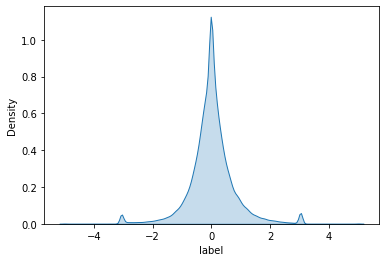

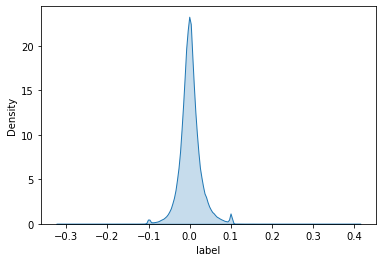

norm data done 

min60     0.211082
max60     0.202849
max20     0.200399
min20     0.199768
max10     0.191882
            ...   
risk60    0.004202
rsv5      0.004050
risk10    0.001784
risk20    0.000908
risk5     0.000000
Name: MI Scores, Length: 68, dtype: float64
count    68.000000
mean      0.089009
std       0.056349
min       0.000000
25%       0.059616
50%       0.081387
75%       0.120479
max       0.211082
Name: MI Scores, dtype: float64
risk5 will be dropped
all works done 



In [6]:
# 特征工程、数据清洗，和拆分数据集
x_train, x_test, y_train, y_test, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument')

In [7]:
# 拟合模型并预测
model = scutquant.auto_lrg(x_train, y_train, method='ols')
pred = model.predict(x_test)
pred = pd.Series(pred, index=x_test.index)
pred += ymean
pred *= ystd

pred

ols method will be used


datetime    instrument
2019-12-31  SZ002422      0.000220
            SZ002456      0.002056
            SZ002460      0.001867
            SZ002466     -0.003886
            SZ002468      0.001537
                            ...   
2021-06-11  SZ300433      0.000192
            SZ300498      0.001868
            SZ300529     -0.001146
            SZ300601     -0.000639
            SZ300628     -0.000513
Length: 101403, dtype: float64

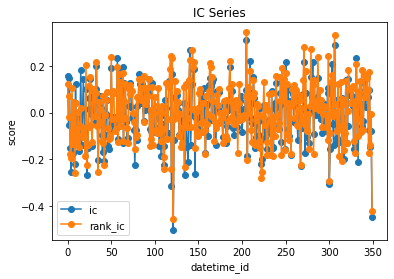

ic= -0.007648891692185611 icir= -0.06549867939087044 rank_ic= 0.0034153637842124648 rank_icir= 0.027649900909284784


In [8]:
# 评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [9]:
# pearson相关系数
r = scutquant.pearson_corr(pred, y_test)
r

-0.030099757504119133